<a href="https://colab.research.google.com/github/mayur7garg/66DaysOfData/blob/main/Day%2018/DCGAN_using_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

**Reference**: [Tensorflow Tutorials: DCGAN](https://www.tensorflow.org/tutorials/generative/dcgan)

## Imports

In [1]:
!pip install imageio

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

## Loading the MNIST dataset

### Loading only the training dataset

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images.shape

(60000, 28, 28, 1)

### Dataset Constants

In [4]:
BUFFER_SIZE = 60_000
BATCH_SIZE = 256

### Using tf.data to shuffle and batch the dataset

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

## Model

### Generator Model

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias = False, input_shape = (100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Sample output from the Generator

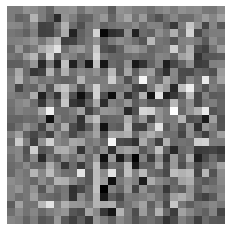

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

plt.axis(False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray');

### Discriminator Model

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = [28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

### Sample output of the Discriminator model
Negative values and positive values mean that the discriminator predicts the image as fake and real respectively.

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00240702]], shape=(1, 1), dtype=float32)


## Loss and Metrics

### Cross Entropy loss for the models and Mean metric to calculate the loss per epoch
Cross entropy loss function here uses logits since the output of the discriminator model ranges from (-infinity, +infinity).

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
gen_mean_loss = tf.keras.metrics.Mean(name = "Generator mean loss")
disc_mean_loss = tf.keras.metrics.Mean(name = "Discriminator mean loss")

### Discriminator Loss
The discriminator must classify the real images as 1 and fake images as 0. Hence the loss is measured as sum of the cross entropy loss for the predictions of the discriminator for the real images as well the fake images.

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss
The generator loss is measured on the output of the discriminator for the fake images only.

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Training

### Adam Optimizers

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Model and optimizer checkpoints

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

### Training constants and seed data for predictions of the generator after every epoch

In [15]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

### Training step per batch

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_mean_loss(gen_loss)
    disc_mean_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Training step per epoch

In [17]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait = True)
        gen_mean_loss.reset_state()
        disc_mean_loss.reset_state()

        for image_batch in dataset:
            train_step(image_batch)

        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print(f"\nEpoch: {epoch + 1}\n")
        print(f'Generator Loss: {gen_mean_loss.result()}')
        print(f'Discriminator Loss: {disc_mean_loss.result()}')
        print (f'Time elapsed: {time.time() - start} s')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

### Utility method to save image predictions of the generator for the seed data

In [18]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (6, 6))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Training and results

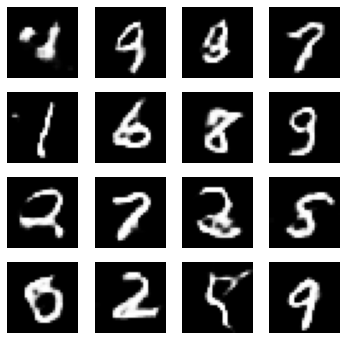

Final Generator Loss: 0.9209142923355103
Final Discriminator Loss: 1.2440069913864136
CPU times: user 6min 38s, sys: 35.3 s, total: 7min 13s
Wall time: 23min 43s


In [19]:
%%time

train(train_dataset, EPOCHS)

print(f'Final Generator Loss: {gen_mean_loss.result()}')
print(f'Final Discriminator Loss: {disc_mean_loss.result()}')

### Restore checkpoint

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Output

### Display the output from the last epoch

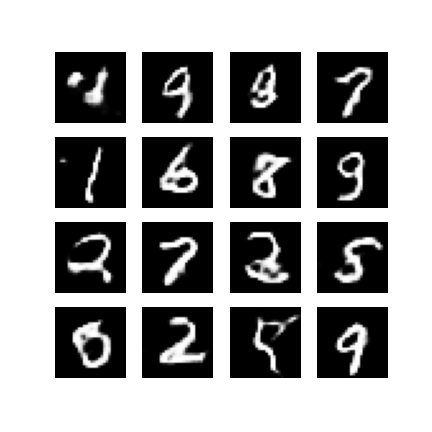

In [21]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

### Display the images from all epochs as GIF

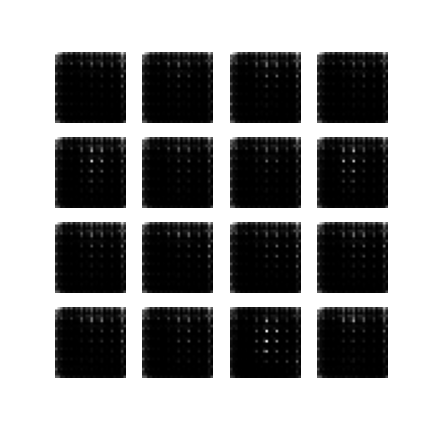

In [22]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)

    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(open('/content/dcgan.gif', 'rb').read())